In [1]:
# SikhiToTheMax/Khalis libraries
import banidb
from anvaad_py import firstLetters
import requests # to get raags
from sentence_transformers import SentenceTransformer, util # for embeddings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Import for creating legend patches
import time
import pyaudio
from google.cloud import speech

# Google Speech-to-Text can be set up using https://www.assemblyai.com/blog/google-speech-to-text-api-python
# For Windows, write the following in the command window from which you launch the jupyter notebook, and then launch the notebook:
# set GOOGLE_APPLICATION_CREDENTIALS="path to json file"

C:\Users\sarvp\anaconda3\envs\gurbani_ai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'
# Supress Hugging Face's Symlinks warning. It wants to use Symlinks to save disk space
# But that requires you to turn on Windows developer mode, which comes with its own risks.

**ASR**

In [3]:
import time
import pyaudio
from google.cloud import speech

# --- Configuration ---
MIN_WORDS_PER_CHUNK = 3 # minimum number of words to process for identifying shabad verse

# Audio recording parameters
RATE = 16000 # Sample rate [Hz]. 16000 samples/second is the industry standard for speech recognition tasks
CHUNK = int(RATE / 10)  # 100ms

In [4]:
# --- Microphone Stream Class ---

class MicrophoneStream:
    """Opens a recording stream from a PyAudio microphone and acts as a Python generator
    that yields audio chunks. It uses a context manager (`with` statement) to
    ensure the microphone is properly closed after use."""
    def __init__(self, rate, chunk):
        self._rate = rate
        self._chunk = chunk
        self._audio_interface = pyaudio.PyAudio()
        self._audio_stream = self._audio_interface.open(
            format=pyaudio.paInt16, # 16 bit integer audio format (standard for speech recognition)
            channels=1, # audio = mono, stereo is not needed for our case
            rate=self._rate,
            input=True, # designate this as an input stream
            frames_per_buffer=self._chunk, # microphone will deliver audio in chunks of this size
            stream_callback=self._fill_buffer, # fill_buffer is called in a background thread when a new audio chunk is ready
        )
        self.closed = False # stream open or closed
        self._buff = [] # a buffer to temporarily store audio chunks from the callback.

    def __enter__(self):
        """Called when entering the 'with' block."""
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """Called when exiting the 'with' block to ensure cleanup."""
        self._audio_stream.stop_stream()
        self._audio_stream.close()
        self.closed = True
        self._audio_interface.terminate()

    def _fill_buffer(self, in_data, frame_count, time_info, status_flags):
        """Callback method to continuously collect data from the audio stream into the buffer.
        The function needs only one argument, but this is a callback method and needs to conform
        to pyaudio callback signature. See https://people.csail.mit.edu/hubert/pyaudio/docs/"""
        self._buff.append(in_data) # append raw audio data chunk to our internal buffer
        return None, pyaudio.paContinue # (audio to be sent to output = None, stream status = continue streaming)

    # Data provider method
    def generator(self):
        """Yields audio chunks from the buffer. This is the main interface for getting audio
        chunks from this class."""
        while not self.closed: # while the microphone stream is active
            if self._buff: # if the buffer has audio chunks
                data = b"".join(self._buff) # join chunks into single block of audio data
                self._buff = [] # clear buffer
                yield data # yield data to the part of the script calling it. The method pauses until next block is requested.
            else: # if buffer is empty
                time.sleep(0.1) # sleep for 0.1 sec to prevent the loop from consuming CPU cycles while waiting for audio

In [5]:
# --- API Response Processing (Word-Based Chunking) ---

def listen_and_process(responses, min_words):
    """
    Processes API responses, buffers final transcripts, and yields text chunks
    based on a minimum word count.
    responses: generator object provided by the Google Cloud client library. This is a live stream.
    min_words: Minimum number of words per chunk
    """
    print(f"Listening... Will output transcribed text in chunks of at least {min_words} words.")
    phrase_buffer = [] # for holding transcribed text as it is received and processed

    for response in responses: # Each response is a single data packet sent by the API
        # The response data packet is a container. The transcription data is inside a list called
        # results. It is possible for the Google API to send an empty results list (e.g. as a 
        # heartbeat). If that's the case, there is nothing to process. So, continue i.e. stop the
        # current loop and jump back to the beginning of the for loop.
        if not response.results:
            continue

        # To understand the following code, it is imperative to understand the structure of the 
        # response. For details, refer to 
        # https://cloud.google.com/speech-to-text/docs/speech-to-text-requests#time-offsets
        # "response": {
        #     "@type": "type.googleapis.com/google.cloud.speech.v1.LongRunningRecognizeResponse",
        #     "results": [
        #       {
        #         "alternatives": [
        #           {
        #             "transcript": "Four score and twenty...(etc)...",
        #             "confidence": 0.97186122,
        #             "words": [
        #               {
        #                 "startTime": "1.300s",
        #                 "endTime": "1.400s",
        #                 "word": "Four"
        #               },
        #               {
        #                 "startTime": "1.400s",
        #                 "endTime": "1.600s",
        #                 "word": "score"
        #               },        
        # So, we have response -> results -> multiple alternatives, and within each alternative
        # alternatives[i] -> transcript, confidence, multiple words
        
        # If a speaker pauses, the API may send a response packet containing MULTIPLE results,
        # one for the speech before the pause and one for after. This loop iterates through
        # every result in the list to ensure that no part of the speech is missed. Without
        # this, we would only ever process the first phrase and ignore the rest.
        for result in response.results:
            # For each result, we check if it contains any 'alternatives' (transcription guesses).
            # If not, we skip to the next result in the list.
            if not result.alternatives:
                continue

            # We take the first alternative, as it is the one with the highest confidence score.
            transcript = result.alternatives[0].transcript

            # Google API sends 2 types of results:
            # 1. Interim results: Fast, low-latency guesses that might change as the speaker continues
            #    e.g. "ਵਾਹਿ" which could be later changed to "ਵਾਹਿਗੁਰੂ"
            # 2. Final results: High-confidence transcriptions confirmed by the API.
            # We will process only the final results to build the chunks.
            if result.is_final:
                # Add the confirmed, cleaned phrase to our temporary buffer.
                phrase_buffer.append(transcript.strip()) # strip() eliminates leading/trailing whitespaces
                
                # Combine all phrases currently in the buffer into a single string to check the word count.
                chunk_text = " ".join(phrase_buffer)
                word_count = len(chunk_text.split())

                # If the total word count meets our minimum requirement, we deliver the chunk.
                if word_count >= min_words:
                    print("-" * 60)
                    print(f"Text Chunk (>= {min_words} words): {chunk_text}")
                    print("-" * 60)
                    
                    # Reset the buffer to start collecting the next chunk from scratch.
                    phrase_buffer = []

In [ ]:
# --- Main Execution Logic ---
# This is where the script is orchestrated.

# Create the client object that will communicate with the Google Speech API.
# It automatically finds credentials from the environment variable.
client = speech.SpeechClient()

# Create a list of common Gurbani phrases. For this to be effective,
# you should expand this list with the tukhs (lines) you expect to hear most.
# This is the "cheat sheet" for the model.
gurbani_phrases = [
    "ਗੁਰੂ ਰਾਮਦਾਸ ਰਾਖਹੁ ਸਰਣਾਈ", "ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ", "ਸਤਿਗੁਰੁ ਤੁਮਰਾ ਕਾਜੁ ਸਵਾਰੈ",
    "ਵਾਹਿਗੁਰੂ", "ਸਤਿਨਾਮ", "ਇਕ ਓਅੰਕਾਰ", "ਜੀ ਕਾ ਖਾਲਸਾ", "ਜੀ ਕੀ ਫਤਿਹ",
    "ਧੰਨ ਗੁਰੂ ਨਾਨਕ", "ਮੇਰਾ ਮਨੁ ਲੋਚੈ ਗੁਰ ਦਰਸਨ ਤਾਈ", "ਸੂਰਾ ਸੋ ਪਹਿਚਾਨੀਐ"
]

# Create the adaptation object with a "boost" to give these phrases priority.
phrase_set = speech.PhraseSet(phrases=[speech.PhraseSet.Phrase(value=p) for p in gurbani_phrases], boost=10.0)
speech_adaptation = speech.SpeechAdaptation(phrase_sets=[phrase_set])

# Create a configuration object telling the API how to process our audio.
config = speech.RecognitionConfig(
    encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=RATE,
    language_code="pa-Guru-IN", # punjabi-Gurumukhi-India
    adaptation=speech_adaptation
)

# Create a more specific configuration for streaming requests.
streaming_config = speech.StreamingRecognitionConfig(
    config=config,
    interim_results=True  # We ask for interim results for potential low-latency use.
)

# A try/except block to gracefully handle stopping the script (e.g., with Ctrl+C).
try:
    # Use the MicrophoneStream as a context manager to handle setup/teardown.
    with MicrophoneStream(RATE, CHUNK) as stream:
        # Get the audio generator from the microphone stream.
        audio_generator = stream.generator()
        # Create a generator of API-formatted requests from our audio generator.
        # This is memory-efficient as it doesn't create a giant list.
        requests = (
            speech.StreamingRecognizeRequest(audio_content=content)
            for content in audio_generator
        )

        # This is the line that starts the two-way communication with the API.
        # It sends the 'requests' generator and returns a 'responses' generator.
        # This is a blocking call that will run as long as the microphone is open.
        responses = client.streaming_recognize(streaming_config, requests)

        # Pass the stream of API responses to our processing function.
        listen_and_process(responses, MIN_WORDS_PER_CHUNK)

except Exception as e:
    # Catches exceptions, including when the user interrupts the script.
    print(f"\nTranscription stopped or an error occurred: {e}")

Listening... Will output transcribed text in chunks of at least 3 words.
------------------------------------------------------------
Text Chunk (>= 3 words): ਤੁਹਾਡਾ ਹਾਲ ਕਿਵੇਂ ਹੈ
------------------------------------------------------------
------------------------------------------------------------
Text Chunk (>= 3 words): ਤੁਸੀਂ ਅੱਜ ਕਿੰਨੀ ਦੇਰ ਪੜ੍ਹਨਗੇ
------------------------------------------------------------
------------------------------------------------------------
Text Chunk (>= 3 words): ਮੈਨੂੰ ਤੇ ਇਹ ਨਹੀਂ ਸਮਝ ਆਉਂਦਾ ਹੈ
------------------------------------------------------------
------------------------------------------------------------
Text Chunk (>= 3 words): ਕੀ ਇਹ ਬੰਦੇ ਰੋਸ ਕੰਮ ਕਿਉਂ ਨਹੀਂ ਕਰਦੇ
------------------------------------------------------------
------------------------------------------------------------
Text Chunk (>= 3 words): ਜੇ ਤੁਸੀਂ ਰੋਜ਼ ਦਾ ਕੰਮ ਰੋਜ਼ਗਾਰ ਨੂ
------------------------------------------------------------
------------------------------------------------

The above model does a great job when you are speaking Punjabi in general, but a horrible job when you play a kirtan recording. Also, the is_final flag is only set to true when a sentence is completed. This sometimes never happens in a kirtan as everything seems like a continious statement

**Exploration**

In [3]:
shabad = banidb.random()

In [4]:
shabad

{'shabad_id': 3570,
 'source_uni': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
 'source_eng': 'Sri Guru Granth Sahib Ji',
 'writer': 'Guru Arjan Dev Ji',
 'ang': 965,
 'verses': [{'verse_id': 41269,
   'verse': 'ਮਃ ੫ ॥',
   'steek': {'en': {'bdb': 'Fifth Mehla:',
     'ms': '5th Guru.',
     'ssk': 'Fifth Mehl:'},
    'pu': {'ss': {'gurmukhi': None, 'unicode': None},
     'ft': {'gurmukhi': '', 'unicode': ''},
     'bdb': {'gurmukhi': None, 'unicode': None},
     'ms': {'gurmukhi': 'pMjvIN pwqSwhI[', 'unicode': 'ਪੰਜਵੀਂ ਪਾਤਸ਼ਾਹੀ।'}},
    'es': {'sn': 'Mejl Guru Aryan, Quinto Canal Divino.'},
    'hi': {'ss': '', 'sts': 'महला ५॥'}},
   'transliteration': {'english': 'mahalaa panjavaa ||',
    'hindi': 'म: ५ ॥',
    'en': 'mahalaa panjavaa ||',
    'hi': 'म: ५ ॥',
    'ipa': 'mahalaa pəŋd͡ʒʋɑ.',
    'ur': 'مÚ ۵ ۔۔'}},
  {'verse_id': 41270,
   'verse': 'ਆਹਰ ਸਭਿ ਕਰਦਾ ਫਿਰੈ ਆਹਰੁ ਇਕੁ ਨ ਹੋਇ ॥',
   'steek': {'en': {'bdb': 'Making all sorts of efforts, they wander around; but they do not make even one effort.',
 

In [5]:
shabad.keys()

dict_keys(['shabad_id', 'source_uni', 'source_eng', 'writer', 'ang', 'verses'])

In [6]:
print(shabad['shabad_id'])

3570


In [7]:
print(shabad['source_uni'])

ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ


In [8]:
print(shabad['writer'])

Guru Arjan Dev Ji


In [9]:
print(shabad['ang'])

965


In [10]:
shabad['verses'][0]

{'verse_id': 41269,
 'verse': 'ਮਃ ੫ ॥',
 'steek': {'en': {'bdb': 'Fifth Mehla:',
   'ms': '5th Guru.',
   'ssk': 'Fifth Mehl:'},
  'pu': {'ss': {'gurmukhi': None, 'unicode': None},
   'ft': {'gurmukhi': '', 'unicode': ''},
   'bdb': {'gurmukhi': None, 'unicode': None},
   'ms': {'gurmukhi': 'pMjvIN pwqSwhI[', 'unicode': 'ਪੰਜਵੀਂ ਪਾਤਸ਼ਾਹੀ।'}},
  'es': {'sn': 'Mejl Guru Aryan, Quinto Canal Divino.'},
  'hi': {'ss': '', 'sts': 'महला ५॥'}},
 'transliteration': {'english': 'mahalaa panjavaa ||',
  'hindi': 'म: ५ ॥',
  'en': 'mahalaa panjavaa ||',
  'hi': 'म: ५ ॥',
  'ipa': 'mahalaa pəŋd͡ʒʋɑ.',
  'ur': 'مÚ ۵ ۔۔'}}

In [11]:
shabad['verses'][1] # starting verse of the shabad

{'verse_id': 41270,
 'verse': 'ਆਹਰ ਸਭਿ ਕਰਦਾ ਫਿਰੈ ਆਹਰੁ ਇਕੁ ਨ ਹੋਇ ॥',
 'steek': {'en': {'bdb': 'Making all sorts of efforts, they wander around; but they do not make even one effort.',
   'ms': 'Man goes about making all efforts, but he makes not one effort to meet the Lord.',
   'ssk': 'Making all sorts of efforts, they wander around; but they do not make even one effort.'},
  'pu': {'ss': {'gurmukhi': 'hy nwnk! mnu`K hor swry au~dm krdw iPrdw hY, pr iek pRBU ƒ ismrn dw au~dm nhIN krdw [',
    'unicode': 'ਹੇ ਨਾਨਕ! ਮਨੁੱਖ ਹੋਰ ਸਾਰੇ ਉੱਦਮ ਕਰਦਾ ਫਿਰਦਾ ਹੈ, ਪਰ ਇਕ ਪ੍ਰਭੂ ਨੂੰ ਸਿਮਰਨ ਦਾ ਉੱਦਮ ਨਹੀਂ ਕਰਦਾ ।'},
   'ft': {'gurmukhi': 'hy BweI! jIv audm qW sB kMmoN vwsqy krqw iPrqw hY, iek prmysr lIey audm nhIN hoqw]',
    'unicode': 'ਹੇ ਭਾਈ! ਜੀਵ ਉਦਮ ਤਾਂ ਸਭ ਕੰਮੋਂ ਵਾਸਤੇ ਕਰਤਾ ਫਿਰਤਾ ਹੈ, ਇਕ ਪਰਮੇਸਰ ਲੀਏ ਉਦਮ ਨਹੀਂ ਹੋਤਾ॥'},
   'bdb': {'gurmukhi': 'hy nwnk! mnu`K hor swry au~dm krdw iPrdw hY, pr iek pRBU ƒ ismrn dw au~dm nhIN krdw [',
    'unicode': 'ਹੇ ਨਾਨਕ! ਮਨੁੱਖ ਹੋਰ ਸਾਰੇ ਉੱਦਮ ਕਰਦਾ ਫਿਰਦਾ ਹੈ, ਪਰ ਇਕ ਪ੍ਰਭੂ ਨੂੰ ਸਿਮਰਨ ਦ

In [12]:
shabad['verses'][-1] # ending verse of the shabad

{'verse_id': 41271,
 'verse': 'ਨਾਨਕ ਜਿਤੁ ਆਹਰਿ ਜਗੁ ਉਧਰੈ ਵਿਰਲਾ ਬੂਝੈ ਕੋਇ ॥੨॥',
 'steek': {'en': {'bdb': 'O Nanak, how rare are those who understand the effort which saves the world. ||2||',
   'ms': 'Nanak, rare is the person, who realises the effort, by which the world is saved.',
   'ssk': 'O Nanak, how rare are those who understand the effort which saves the world. ||2||'},
  'pu': {'ss': {'gurmukhi': 'ijs au~dm dI rwhIN jgq ivkwrW qoN bc skdw hY (aus au~dm ƒ) koeI ivrlw mnu`K smJdw hY [',
    'unicode': 'ਜਿਸ ਉੱਦਮ ਦੀ ਰਾਹੀਂ ਜਗਤ ਵਿਕਾਰਾਂ ਤੋਂ ਬਚ ਸਕਦਾ ਹੈ (ਉਸ ਉੱਦਮ ਨੂੰ) ਕੋਈ ਵਿਰਲਾ ਮਨੁੱਖ ਸਮਝਦਾ ਹੈ ।'},
   'ft': {'gurmukhi': 'sRI gurU jI kihqy hYN: ijs moK ky swDno rUp audm kr ky jIv jnm mrn qy bc jwvy iqs audm ko koeI ivrlw hI jwnqw hY]2]',
    'unicode': 'ਸ੍ਰੀ ਗੁਰੂ ਜੀ ਕਹਿਤੇ ਹੈਂ: ਜਿਸ ਮੋਖ ਕੇ ਸਾਧਨੋ ਰੂਪ ਉਦਮ ਕਰ ਕੇ ਜੀਵ ਜਨਮ ਮਰਨ ਤੇ ਬਚ ਜਾਵੇ ਤਿਸ ਉਦਮ ਕੋ ਕੋਈ ਵਿਰਲਾ ਹੀ ਜਾਨਤਾ ਹੈ॥੨॥'},
   'bdb': {'gurmukhi': 'ijs au~dm dI rwhIN jgq ivkwrW qoN bc skdw hY (aus au~dm ƒ) koeI ivrlw mnu`K smJdw hY [',
    'unicode'

**Searching a shabad**

In [13]:
gurbani_text = "ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ" # Thir ghar baiso har jan piaare

In [14]:
%%time
# Try searching 10 times across all sources, all angs, all angs, and all writers
# The default search options for banidb.search() are:
# banidb.search(query, searchtype=1, source='all', larivaar=False,
#              ang=None, raag=None, writer='all', page=1, results=None)
for i in range(10):
    ascii_query = firstLetters(gurbani_text)
    shabad_data = banidb.search(ascii_query)

CPU times: total: 188 ms
Wall time: 13.1 s


In [15]:
print(ascii_query)
shabad_data

ਥਘਬਹਜਪ


{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

Now, let's find a shabad using a restricted search space

In [16]:
shabad_data['pages_data']['page_1'][0]

{'shabad_id': 628,
 'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
 'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
  'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
 'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
  'en': 'Sri Guru Granth Sahib Ji',
  'ang': 201,
  'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
  'raagen': 'Raag Gauree',
  'writer': 'Guru Arjan Dev Ji'}}

To restrict search space, the options in banidb.search are:
1. source
2. ang
3. raag
4. writer<br>
Let's try to extract these from shabad_data

*Source*

In [17]:
banidb.sources()

[{'source_id': 'A',
  'source_uni': 'ਅੰਮ੍ਰਿਤ ਕੀਰਤਨ',
  'source_eng': 'Amrit Keertan'},
 {'source_id': 'B',
  'source_uni': 'ਭਾਈ ਗੁਰਦਾਸ ਜੀ ਵਾਰਾਂ',
  'source_eng': 'Bhai Gurdas Ji Vaaran'},
 {'source_id': 'D', 'source_uni': 'ਦਸਮ ਬਾਣੀ', 'source_eng': 'Dasam Bani'},
 {'source_id': 'G',
  'source_uni': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
  'source_eng': 'Sri Guru Granth Sahib Ji'},
 {'source_id': 'N',
  'source_uni': 'ਭਾਈ ਨੰਦ ਲਾਲ ਜੀ ਵਾਰਾਂ',
  'source_eng': 'Bhai Nand Lal Ji Vaaran'},
 {'source_id': 'R',
  'source_uni': 'ਰਹਿਤਨਾਮੇ ਅਤੇ ਪੰਥਕ ਲਿਖ਼ਤਾਂ',
  'source_eng': 'Codes of Conduct and Other Panthic Sources'},
 {'source_id': 'S',
  'source_uni': 'ਭਾਈ ਗੁਰਦਾਸ ਸਿੰਘ ਜੀ ਵਾਰਾਂ',
  'source_eng': 'Bhai Gurdas Singh Ji Vaaran'}]

I think that the search space can be universally restricted to B (I don't know how this is different from S), D, G, N from https://banidbpy.readthedocs.io/en/latest/sources.html but it seems that the search function only allows for a string i.e. a single source instead of multiple ones: https://banidbpy.readthedocs.io/en/latest/searchdb.html

In [18]:
# banidb.search() accepts source ID, not the source in english or unicode (https://banidbpy.readthedocs.io/en/latest/sources.html)
# Map 'source_eng', which is what we get from banidb.search()'s output back to source ID so that we can use that in subsequent
# calls to banidb.search()
source_to_id_dict = {}
for item in banidb.sources():
    source_to_id_dict[item['source_eng']] = item['source_id']
source_to_id_dict

{'Amrit Keertan': 'A',
 'Bhai Gurdas Ji Vaaran': 'B',
 'Dasam Bani': 'D',
 'Sri Guru Granth Sahib Ji': 'G',
 'Bhai Nand Lal Ji Vaaran': 'N',
 'Codes of Conduct and Other Panthic Sources': 'R',
 'Bhai Gurdas Singh Ji Vaaran': 'S'}

In [19]:
# Extract source for the shabad
shabad_data['pages_data']['page_1'][0]['source']

{'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
 'en': 'Sri Guru Granth Sahib Ji',
 'ang': 201,
 'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
 'raagen': 'Raag Gauree',
 'writer': 'Guru Arjan Dev Ji'}

In [20]:
# Sanity check
shabad_source = shabad_data['pages_data']['page_1'][0]['source']['en']
print(shabad_source)
banidb.search(ascii_query, source = source_to_id_dict.get(shabad_source))

Sri Guru Granth Sahib Ji


{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

*Ang*

In [21]:
shabad_ang = shabad_data['pages_data']['page_1'][0]['source']['ang']
print(shabad_ang)
# Sanity check
banidb.search(ascii_query, ang = shabad_ang)

201


{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

*Raag*

In [22]:
try:
    raags = banidb.raags() # If this fails, try the one below
except:
    print("banidb.raags() doesn't work. Retrieving raags directly from the API")
    def get_raags_directly():
        """
        Fetches the list of raags directly from the BaniDB API,
        bypassing the banidb.raags() function.
        """
        # The API endpoint that the banidb library uses for raags
        url = "https://api.banidb.com/v2/raags"
        
        try:
            response = requests.get(url)
            # Raise an exception if the request returned an error (e.g., 404, 500)
            response.raise_for_status()
            
            # Convert the JSON response to a Python dictionary
            data = response.json()
            
            # The actual raag data is in the 'rows' key, skipping the header row
            raags_list = []
            for row in data['rows'][1:]:
                raag = {
                    'raag_id': row.get('RaagID'),
                    'raag_uni': row.get('RaagUnicode'),
                    'raag_eng': row.get('RaagEnglish')
                }
                raags_list.append(raag)
                
            return raags_list
    
        except requests.exceptions.RequestException as e:
            print(f"A network error occurred: {e}")
            return None
        except (KeyError, IndexError) as e:
            print(f"The API response format may have changed. Error: {e}")
            return None

        # --- Usage ---
    raags = get_raags_directly()
        
if raags:
    print("Successfully retrieved:")
    # Print the first 5 raags as an example
    for raag in raags:
        print(raag)

Successfully retrieved:
{'raag_id': 1, 'raag_uni': 'ਜਪ', 'raag_eng': 'Jap'}
{'raag_id': 2, 'raag_uni': 'ਸੋ ਦਰ', 'raag_eng': 'So Dar'}
{'raag_id': 3, 'raag_uni': 'ਸੋ ਪੁਰਖ', 'raag_eng': 'So Purakh'}
{'raag_id': 4, 'raag_uni': 'ਸੋਹਿਲਾ', 'raag_eng': 'Sohila'}
{'raag_id': 5, 'raag_uni': 'ਸਿਰੀ ਰਾਗੁ', 'raag_eng': 'Siree Raag'}
{'raag_id': 6, 'raag_uni': 'ਰਾਗੁ ਮਾਝ', 'raag_eng': 'Raag Maajh'}
{'raag_id': 7, 'raag_uni': 'ਰਾਗੁ ਗਉੜੀ', 'raag_eng': 'Raag Gauree'}
{'raag_id': 8, 'raag_uni': 'ਰਾਗੁ ਆਸਾ', 'raag_eng': 'Raag Aasaa'}
{'raag_id': 9, 'raag_uni': 'ਰਾਗੁ ਗੂਜਰੀ', 'raag_eng': 'Raag Gujri'}
{'raag_id': 10, 'raag_uni': 'ਰਾਗੁ ਦੇਵਗੰਧਾਰੀ', 'raag_eng': 'Raag Dayv Gandhaaree'}
{'raag_id': 11, 'raag_uni': 'ਰਾਗੁ ਬਿਹਾਗੜਾ', 'raag_eng': 'Raag Bihaagraa'}
{'raag_id': 12, 'raag_uni': 'ਰਾਗੁ ਵਡਹੰਸੁ', 'raag_eng': 'Raag Vadhans'}
{'raag_id': 13, 'raag_uni': 'ਰਾਗੁ ਸੋਰਠਿ', 'raag_eng': 'Raag Sorath'}
{'raag_id': 14, 'raag_uni': 'ਰਾਗੁ ਧਨਾਸਰੀ', 'raag_eng': 'Raag Dhanaasree'}
{'raag_id': 15, 'raag_uni': 'ਰਾਗੁ ਜੈਤਸਰੀ', '

In [23]:
# banidb.search() accepts source ID, not the source in english or unicode (https://banidbpy.readthedocs.io/en/latest/sources.html)
# Map 'raag_eng', which is what we get from banidb.search()'s output back to 'raag_id' so that we can use that in subsequent
# calls to banidb.search()
raag_to_id_dict = {}
for item in raags: # or banidb.raags() if it doesn't fail
    raag_to_id_dict[item['raag_eng']] = item['raag_id']
raag_to_id_dict

{'Jap': 1,
 'So Dar': 2,
 'So Purakh': 3,
 'Sohila': 4,
 'Siree Raag': 5,
 'Raag Maajh': 6,
 'Raag Gauree': 7,
 'Raag Aasaa': 8,
 'Raag Gujri': 9,
 'Raag Dayv Gandhaaree': 10,
 'Raag Bihaagraa': 11,
 'Raag Vadhans': 12,
 'Raag Sorath': 13,
 'Raag Dhanaasree': 14,
 'Raag Jaithsree': 15,
 'Raag Todee': 16,
 'Raag Baihaaree': 17,
 'Raag Tilang': 18,
 'Raag Soohee': 19,
 'Raag Bilaaval': 20,
 'Raag Gond': 21,
 'Raag Raamkalee': 22,
 'Raag Nat Naaraayan': 23,
 'Raag Maalee Gauraa': 24,
 'Raag Maaroo': 25,
 'Raag Tukhaari': 26,
 'Raag Kaydaaraa': 27,
 'Raag Bhairao': 28,
 'Raag Basant': 29,
 'Raag Saarang': 30,
 'Raag Malaar': 31,
 'Raag Kaanraa': 32,
 'Raag Kalyaan': 33,
 'Raag Prabhaatee': 34,
 'Raag Jaijaavantee': 35,
 'Salok Sehskritee': 36,
 'Fifth Mehl, Gaathaa': 37,
 'Phunhay Fifth Mehl': 38,
 'Chaubolas Fifth Mehl': 39,
 'Salok Kabeer Jee': 40,
 'Salok Fareed Jee': 41,
 'Svaiyay Mehl 5': 42,
 'Salok Vaaraan Thay Vadheek': 43,
 'Salok Mehl 9': 44,
 'Mundhaavanee Fifth Mehl': 45,
 'Raa

In [24]:
shabad_raag = shabad_data['pages_data']['page_1'][0]['source']['raagen']
print(shabad_raag)
# Sanity check
banidb.search(ascii_query, raag = raag_to_id_dict.get(shabad_raag))

Raag Gauree


{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

*Writer*

In [25]:
banidb.writers()

[{'writer_id': 1, 'writer_name': 'Guru Nanak Dev Ji'},
 {'writer_id': 2, 'writer_name': 'Guru Angad Dev Ji'},
 {'writer_id': 3, 'writer_name': 'Guru Amar Daas Ji'},
 {'writer_id': 4, 'writer_name': 'Guru Raam Daas Ji'},
 {'writer_id': 5, 'writer_name': 'Guru Arjan Dev Ji'},
 {'writer_id': 6, 'writer_name': 'Guru Tegh Bahaadur Ji'},
 {'writer_id': 7, 'writer_name': 'Bhagat Bheekhan Ji'},
 {'writer_id': 8, 'writer_name': 'Bhagat Beni Ji'},
 {'writer_id': 9, 'writer_name': 'Bhagat Dhannaa Ji'},
 {'writer_id': 10, 'writer_name': 'Bhagat Trilochan Ji'},
 {'writer_id': 11, 'writer_name': 'Bhagat Jaidev Ji'},
 {'writer_id': 12, 'writer_name': 'Bhagat Kabeer Ji'},
 {'writer_id': 13, 'writer_name': 'Bhagat Naam Dev Ji'},
 {'writer_id': 14, 'writer_name': 'Bhagat Peepaa Ji'},
 {'writer_id': 15, 'writer_name': 'Bhagat Parmaanand Ji'},
 {'writer_id': 16, 'writer_name': 'Bhagat Ravi Daas Ji'},
 {'writer_id': 17, 'writer_name': 'Bhagat Raamaanand Ji'},
 {'writer_id': 18, 'writer_name': 'Bhagat Surda

In [26]:
# banidb.search() accepts writer ID, not the writer name or unicode (https://banidbpy.readthedocs.io/en/latest/writers.html)
# Map 'writer_name', which is what we get from banidb.search()'s output back to 'writer_id' so that we can use that in subsequent
# calls to banidb.search()
writer_to_id_dict = {}
for item in banidb.writers():
    writer_to_id_dict[item['writer_name']] = item['writer_id']
writer_to_id_dict

{'Guru Nanak Dev Ji': 1,
 'Guru Angad Dev Ji': 2,
 'Guru Amar Daas Ji': 3,
 'Guru Raam Daas Ji': 4,
 'Guru Arjan Dev Ji': 5,
 'Guru Tegh Bahaadur Ji': 6,
 'Bhagat Bheekhan Ji': 7,
 'Bhagat Beni Ji': 8,
 'Bhagat Dhannaa Ji': 9,
 'Bhagat Trilochan Ji': 10,
 'Bhagat Jaidev Ji': 11,
 'Bhagat Kabeer Ji': 12,
 'Bhagat Naam Dev Ji': 13,
 'Bhagat Peepaa Ji': 14,
 'Bhagat Parmaanand Ji': 15,
 'Bhagat Ravi Daas Ji': 16,
 'Bhagat Raamaanand Ji': 17,
 'Bhagat Surdaas Ji': 18,
 'Bhagat Saadhnaa Ji': 19,
 'Bhagat Sain Ji': 20,
 'Bhagat Sheikh Fareed Ji': 21,
 'Bhai Gurdaas Ji': 22,
 'Bhatt Bal': 30,
 'Bhatt Sathaa & Balvand': 31,
 'Bhatt (Baba) Sundar': 32,
 'Bhatt Gayandh': 33,
 'Bhatt Harbans': 34,
 'Bhatt Bhikhaa': 35,
 'Bhatt Jal Jaalap': 37,
 'Bhatt Keerath ': 38,
 'Bhatt Kal': 41,
 'Bhatt Kall Sahaar': 40,
 'Bhatt Mathuraa': 42,
 'Bhai Mardana': 43,
 'Bhatt Nal': 44,
 'Bhatt Sal': 45,
 'Bhatt Tal': 46,
 'Guru Gobind Singh Ji': 47,
 'Bhai Nand Lal Ji': 48,
 'Bhai Gurdas Singh Ji': 49,
 'Bhai Da

In [27]:
shabad_writer = shabad_data['pages_data']['page_1'][0]['source']['writer']
print(shabad_writer)
# Sanity check
banidb.search(ascii_query, writer = writer_to_id_dict.get(shabad_writer))

Guru Arjan Dev Ji


{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

*Checking speed for restricted space search*

In [28]:
shabad_source_id = source_to_id_dict.get(shabad_source)
shabad_raag_id   = raag_to_id_dict.get(shabad_raag)
shabad_writer_id = writer_to_id_dict.get(shabad_writer)

In [29]:
%%time
for i in range(10):
    ascii_query = firstLetters(gurbani_text)
    shabad_data = banidb.search(ascii_query, source=shabad_source_id, ang=shabad_ang, raag=shabad_raag_id, writer=shabad_writer_id)

CPU times: total: 141 ms
Wall time: 13.1 s


In [30]:
banidb.search(ascii_query, source=shabad_source_id, ang=shabad_ang, raag=shabad_raag_id, writer=shabad_writer_id)

{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

Wow. Seems like this didn't help at all. Also, while it is good to see how to improve the tuk/line retrieval time, at the end of the day, we don't even know if we can get ASR correct. If the ASR is incorrect, then the first letters would be incorrect too, and doing a banidb.search() would be futile no matter how optimized it is. Similarly, it is very common for ragis to repeat phrases e.g. "satgur tumre kaaj savare, kaaj savare, kaaj savare". This would also cause a banidb.search() to fail. So, a better approach is to take the ASR output and convert that into an embedding that can then be compared against the verses of the shabad. To do so, we first need to get all the verses of the shabad.

**Shabad verses and embeddings**

It is great that we can identify a shabad from across all Sikh scriptures. 
1. We have also found that restricting the search space in banidb.search() doesn't seem to improve the time required to identify.
2. In addition, banidb would require us to have the correct search query to find a shabad. Since we will rely on ASR for getting the text for the gurbani tuk/line, we can't be certain of that. <br>

So, we need to find a new method. Here is the proposed approach:
1. Identify the shabad by using banidb search via skip-gram approach. That is, take the whole text sequence and split it into multiple parts. Then, pass this into banidb.search(). If the text sequence's first letters using ASR turn out to be "tgvhjp" ("thir ghar baiso har jan piaare"), where "baiso" is incorrectly identified as "vaiso", then we can pass multiple queries by splitting - "tgvhjp", "gvhj", "tvhj", "vhjp" etc. The return from these queries can be used to identify shabad IDs. The median of these results can be picked as the relevant shabad. We can also store other results in memory in case the search query fails in the future.
2. Once the shabad is identified, we will get all its verses using banidb.shabad(). Then, we will no longer use the skip-gram approach for subsequent searches. Instead, we will use the more powerful method of embeddings. We will embed the ASR output as embeddings and compare them to the embeddings of the verses for that shabad. This search space should be quite small and we hope to be able to identify the verse fairly quickly.
3. We need to continuously monitor the words being sung and ensure that the verse/tuk identified is same as the previous one. If it changes (with high confidence), we need to switch to giving a new verse as the output.

In [31]:
import re

In [32]:
def clean_gurbani_verse(text):
    """
    Removes verse numbers, punctuation, and the word 'Rahaao' from a Gurbani line.
    This is needed because in ASR, we will never get these in the output as no raagi
    sings these.
    """
    # Remove numbers (both Gurmukhi and Arabic)
    text = re.sub(r'[\u0A66-\u0A6F0-9]+', '', text)
    # Remove the word 'Rahaao' (ਰਹਾਉ)
    text = text.replace('ਰਹਾਉ', '')
    # Remove Danda (॥), Visarg (ਃ), and other common punctuation
    text = re.sub(r'[॥।☬ਃ|]', '', text)
    # Remove extra spaces and strip whitespace from ends
    text = ' '.join(text.split())
    return text

In [33]:
# Sanity check
shabad_id = shabad_data['pages_data']['page_1'][0]['shabad_id']
shabad_data2 = banidb.shabad(shabad_id)
[(clean_gurbani_verse(item['verse']), item['verse']) for item in shabad_data2['verses']]

[('ਗਉੜੀ ਮਹਲਾ', 'ਗਉੜੀ ਮਹਲਾ ੫ ॥'),
 ('ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ', 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥'),
 ('ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ ॥੧॥ ਰਹਾਉ ॥'),
 ('ਦੁਸਟ ਦੂਤ ਪਰਮੇਸਰਿ ਮਾਰੇ', 'ਦੁਸਟ ਦੂਤ ਪਰਮੇਸਰਿ ਮਾਰੇ ॥'),
 ('ਜਨ ਕੀ ਪੈਜ ਰਖੀ ਕਰਤਾਰੇ', 'ਜਨ ਕੀ ਪੈਜ ਰਖੀ ਕਰਤਾਰੇ ॥੧॥'),
 ('ਬਾਦਿਸਾਹ ਸਾਹ ਸਭ ਵਸਿ ਕਰਿ ਦੀਨੇ', 'ਬਾਦਿਸਾਹ ਸਾਹ ਸਭ ਵਸਿ ਕਰਿ ਦੀਨੇ ॥'),
 ('ਅੰਮ੍ਰਿਤ ਨਾਮ ਮਹਾ ਰਸ ਪੀਨੇ', 'ਅੰਮ੍ਰਿਤ ਨਾਮ ਮਹਾ ਰਸ ਪੀਨੇ ॥੨॥'),
 ('ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ', 'ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ ॥'),
 ('ਸਾਧਸੰਗਤਿ ਮਿਲਿ ਕੀਨੋ ਦਾਨੁ', 'ਸਾਧਸੰਗਤਿ ਮਿਲਿ ਕੀਨੋ ਦਾਨੁ ॥੩॥'),
 ('ਸਰਣਿ ਪਰੇ ਪ੍ਰਭ ਅੰਤਰਜਾਮੀ', 'ਸਰਣਿ ਪਰੇ ਪ੍ਰਭ ਅੰਤਰਜਾਮੀ ॥'),
 ('ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ', 'ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ ॥੪॥੧੦੮॥')]

Using sentence-transformers/distiluse-base-multilingual-cased-v2 gives poor results. Same with ai4bharat/indic-bert' but that's because it is not a sentence transformer.

In [34]:
from sentence_transformers import SentenceTransformer, util, models
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

class ShabadMatcher:
    def __init__(self, model_name: str, pooling: str = 'cls', use_cls: bool = False):
        self.model_name = model_name
        self.pooling = pooling
        self.use_cls = use_cls

        if model_name == "ai4bharat/indic-bert":
            self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
            self.model = AutoModel.from_pretrained(model_name)
            self.encode_fn = self._encode_indic_bert

        elif model_name == "bert-base-multilingual-cased":
            word_embedding_model = models.Transformer(model_name, max_seq_length=128)
            pooling_model = models.Pooling(
                word_embedding_model.get_word_embedding_dimension(),
                pooling_mode_mean_tokens=(pooling == 'mean'),
                pooling_mode_cls_token=(pooling == 'cls'),
                pooling_mode_max_tokens=False
            )
            self.model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
            self.encode_fn = self._encode_sbert

        elif model_name in [
            "l3cube-pune/indic-sentence-similarity-sbert",
            "sentence-transformers/LaBSE",
            "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
        ]:
            self.model = SentenceTransformer(model_name)
            self.encode_fn = self._encode_sbert

        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def _encode_sbert(self, texts):
        return self.model.encode(texts, convert_to_tensor=True)

    def _encode_indic_bert(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        inputs = self.tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs)
        if self.use_cls:
            embeddings = outputs.last_hidden_state[:, 0]
        else:
            mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size())
            masked_embeddings = outputs.last_hidden_state * mask
            summed = masked_embeddings.sum(dim=1)
            counts = mask.sum(dim=1)
            embeddings = summed / counts
        return F.normalize(embeddings, p=2, dim=1)

    def match(self, shabad_data, asr_output_phrase, min_words=3):
        if len(asr_output_phrase.strip().split()) < min_words:
            print(f"[Skipping] Phrase too short (min_words={min_words}): '{asr_output_phrase}'")
            return None
            
        verses = [clean_gurbani_verse(item['verse']) for item in shabad_data['verses']]
        shabad_embeddings = self.encode_fn(verses)
        asr_embedding = self.encode_fn(asr_output_phrase)

        if isinstance(shabad_embeddings, torch.Tensor):
            scores = F.cosine_similarity(asr_embedding, shabad_embeddings)
            best_idx = scores.argmax()
            best_score = scores[best_idx]
        else:
            scores = util.cos_sim(asr_embedding, shabad_embeddings)
            best_idx = scores.argmax()
            best_score = scores[0][best_idx]

        return {
            'best_verse': verses[best_idx],
            'score': round(float(best_score), 2),
            'index': int(best_idx)
        }

In [35]:
models_to_test = {
    "BBMC": ShabadMatcher("bert-base-multilingual-cased", pooling="cls"),
    "L3Cube": ShabadMatcher("l3cube-pune/indic-sentence-similarity-sbert"),
    "LaBSE": ShabadMatcher("sentence-transformers/LaBSE"),
    "MiniLM": ShabadMatcher("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"),
    "IndicBERT (CLS)": ShabadMatcher("ai4bharat/indic-bert", use_cls=True),
    "IndicBERT (Mean)": ShabadMatcher("ai4bharat/indic-bert", use_cls=False)
}

In [36]:
def test_phrases(asr_phrases, correct_indices):
    results_verse =  {key:[] for key in models_to_test.keys()}
    results_status =  {key:[] for key in models_to_test.keys()}
    results_score =  {key:[] for key in models_to_test.keys()}
    assert(len(asr_phrases) == len(correct_indices))
    for i, phrase in enumerate(asr_phrases):
        print(f"\n------For {phrase}------")
        for name, matcher in models_to_test.items():
            result = matcher.match(shabad_data2, phrase)
            status = False if result is None else int(result['index'] == correct_indices[i])
            results_status[name].append(status)
            verse = None if result is None else result['best_verse']
            results_verse[name].append(verse)
            score = None if result is None else result['score']
            results_score[name].append(score)
            print(f"{name}: {result}. Correct? {bool(status) if status is not None else status}")
    return results_status, results_verse, results_score

In [37]:
def plot_similarity_by_status(models_to_test, statuses, scores):
    """
    Creates a 3x2 grid of bar plots showing similarity scores,
    grouped and sorted by status, with a clear legend.
    """
    fig, axs = plt.subplots(3, 2, figsize=(15, 13))
    axs = axs.flatten()

    for i, model in enumerate(models_to_test):
        status_list = statuses.get(model, [])
        score_list = scores.get(model, [])

        # Separate data by status
        status_1_data = sorted(
            [(score_list[j], f'Inst {j}') for j, s in enumerate(status_list) if s == 1],
            key=lambda x: x[0], reverse=True
        )
        status_0_data = sorted(
            [(score_list[j], f'Inst {j}') for j, s in enumerate(status_list) if s == 0],
            key=lambda x: x[0], reverse=True
        )
        
        # Unzip sorted data, handling cases where a status might be missing
        scores_1, labels_1 = zip(*status_1_data) if status_1_data else ([], [])
        scores_0, labels_0 = zip(*status_0_data) if status_0_data else ([], [])

        # Combine for plotting
        combined_scores = list(scores_1) + list(scores_0)
        combined_labels = list(labels_1) + list(labels_0)
        combined_colors = ['tab:blue'] * len(scores_1) + ['tab:orange'] * len(scores_0)
        
        ax = axs[i]
        if combined_scores:
            ax.bar(range(len(combined_scores)), combined_scores, color=combined_colors)
        
        ax.set_title(model)
        ax.set_xlabel('Instance')
        ax.set_ylabel('Similarity Score')
        ax.set_ylim(np.min(combined_scores)-0.01, np.max(combined_scores)+0.01)
        ax.set_xticks(range(len(combined_labels)))
        ax.set_xticklabels(combined_labels, rotation=45, ha='right')

    # Create legend handles and add them to the figure just once
    legend_patch_1 = mpatches.Patch(color='tab:blue', label='Correct verse')
    legend_patch_0 = mpatches.Patch(color='tab:orange', label='Incorrect verse')
    fig.legend(handles=[legend_patch_1, legend_patch_0], loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for the legend
    plt.show()

In [38]:
short_asr_phrases = [
    'ਦੁਸਟ', 'ਦੁਸ਼ਟ', 'ਦੁਸਟ ਦੂਤ', 'ਕਰ ਦੀਨੇ', 'ਕਰਤਾਰੇ', 'ਕੀਨੋ ਦਾਨ',
    'ਦਾਨ', 'ਨਿਰਭੌ', 'ਸਾਧ ਸੰਗ', 'ਸਾਧ', 'ਅੰਤਰ', 'ਜਾਮੀ', 'ਪਕੜੀ ਪ੍ਰਭ'
]
short_asr_correct = [3, 3, 3, 5, 4, 8,
                     8, 7, 8, 8, 9, 9, 10]
statuses, verses, scores = test_phrases(short_asr_phrases, short_asr_correct)


------For ਦੁਸਟ------
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
BBMC: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
L3Cube: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
LaBSE: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
MiniLM: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
IndicBERT (CLS): None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
IndicBERT (Mean): None. Correct? False

------For ਦੁਸ਼ਟ------
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
BBMC: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
L3Cube: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
LaBSE: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
MiniLM: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
IndicBERT (CLS): None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
IndicBER

In [39]:
# 3 word phrases, all beginning and ending within the same verse (ideal use case)
long_asr_phrases = [
    'ਸਤਗੁਰ ਤੁਮਰੇ ਕਾਜ', 'ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'ਦੁਸ਼ਟ ਦੂਤ ਪਰਮੇਸਰ', 'ਦੂਤ ਪਰਮੇਸਰ ਮਾਰੇ', 'ਜਨ ਕੀ ਪੈਜ', 'ਕੀ ਪੈਜ ਰਖੀ', 'ਪੈਜ ਰਖੀ ਕਰਤਾਰੇ',
    'ਨਿਰਭੌ ਹੋ ਭਜੋ', 'ਹੋ ਭਜੋ ਭਗਵਾਨ', 'ਹੋ ਭਜੋ ਪਗਵਾਨ', 'ਬਾਦ ਸ਼ਾਹ ਸ਼ਾਹ', 'ਸ਼ਾਹ ਸ਼ਾਹ ਸਬ', 'ਵੱਸ ਕਰ ਦੀਨੇ', 'ਅੰਮ੍ਰਿਤ ਨਾਮ ਮਹਾ']
long_asr_correct = [2, 2, 3, 3, 4, 4, 4,
                       7, 7, 7, 5, 5, 5, 6]
    
long_statuses, long_verses, long_scores = test_phrases(long_asr_phrases, long_asr_correct)


------For ਸਤਗੁਰ ਤੁਮਰੇ ਕਾਜ------
BBMC: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.98, 'index': 2}. Correct? True
L3Cube: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.86, 'index': 2}. Correct? True
LaBSE: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.76, 'index': 2}. Correct? True
MiniLM: {'best_verse': 'ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ', 'score': 0.95, 'index': 7}. Correct? False
IndicBERT (CLS): {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 1.0, 'index': 2}. Correct? True
IndicBERT (Mean): {'best_verse': 'ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ', 'score': 0.82, 'index': 7}. Correct? False

------For ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ------
BBMC: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.98, 'index': 2}. Correct? True
L3Cube: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.78, 'index': 2}. Correct? True
LaBSE: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.62, 'index': 2}. Correct? True
MiniLM: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.88, 'index': 2}. Correct? True
IndicB

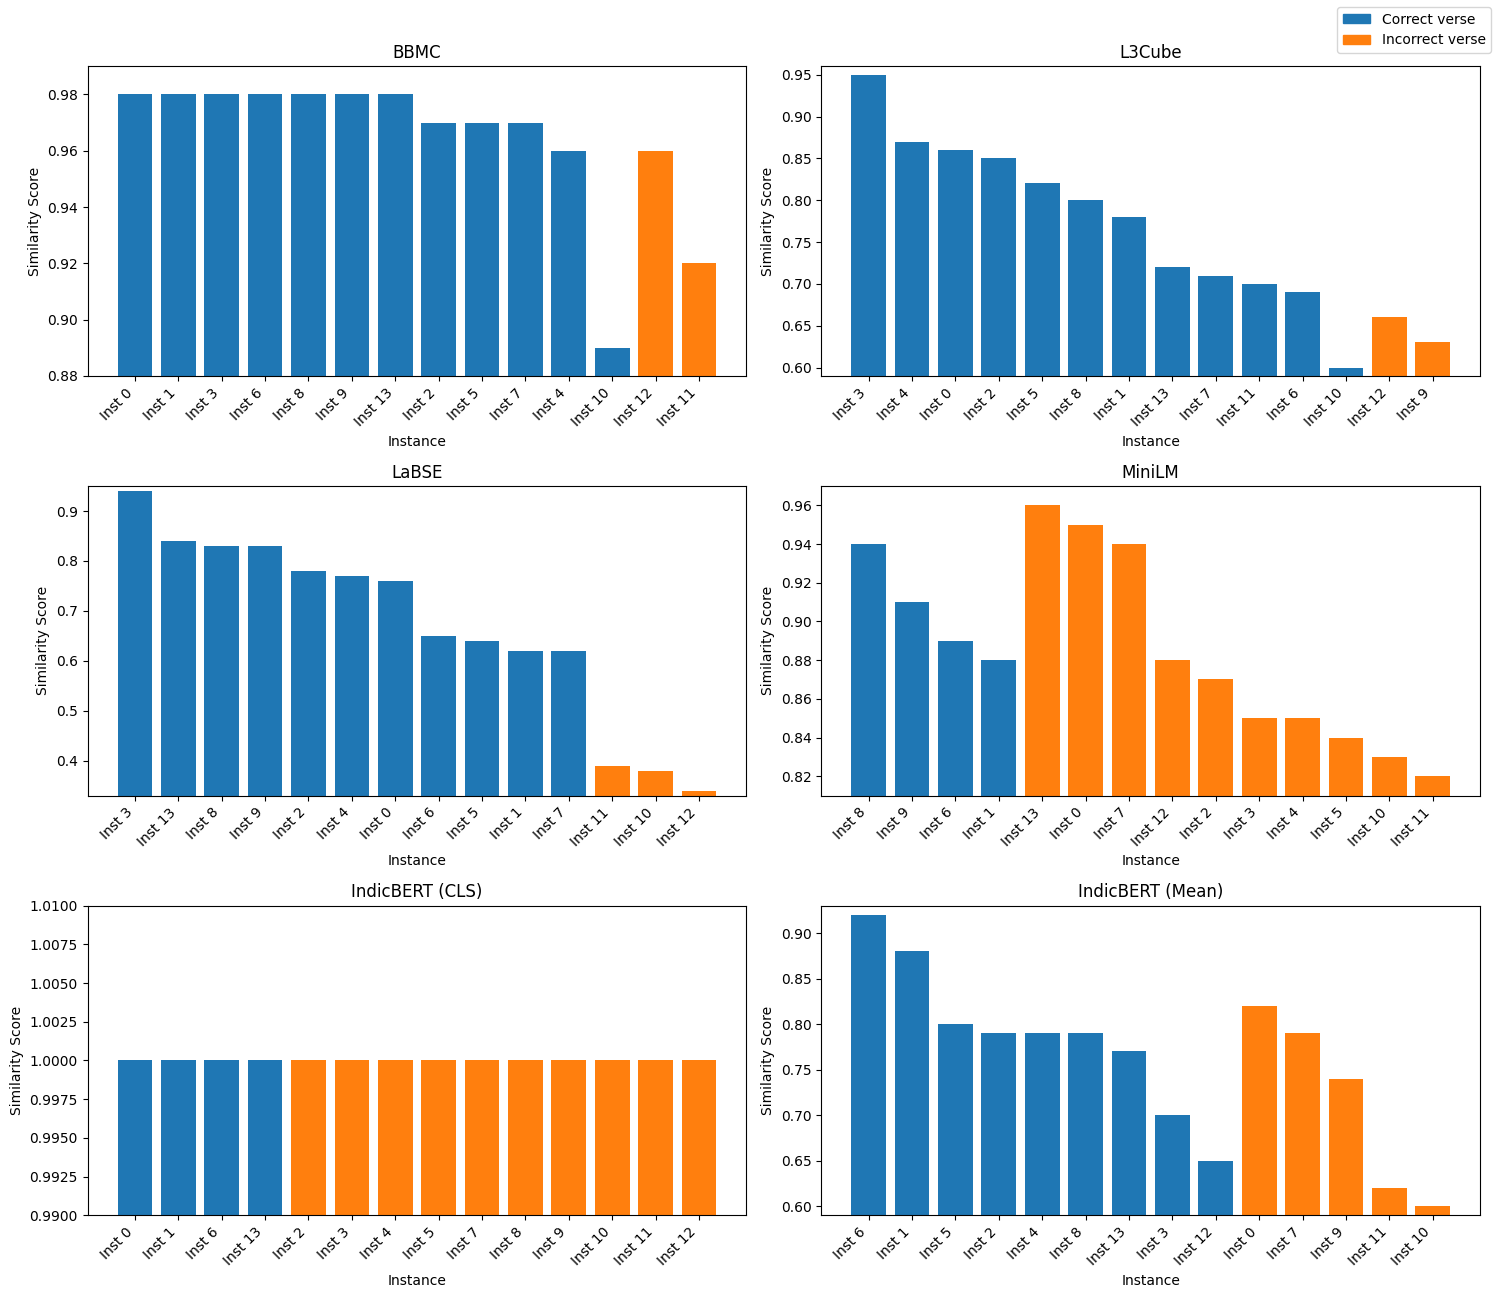

In [40]:
plot_similarity_by_status(models_to_test, long_statuses, long_scores)

0 'ਗਉੜੀ ਮਹਲਾ',
1 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ',
2 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ',
3 'ਦੁਸਟ ਦੂਤ ਪਰਮੇਸਰਿ ਮਾਰੇ',
4 'ਜਨ ਕੀ ਪੈਜ ਰਖੀ ਕਰਤਾਰੇ',
5 'ਬਾਦਿਸਾਹ ਸਾਹ ਸਭ ਵਸਿ ਕਰਿ ਦੀਨੇ',
6 'ਅੰਮ੍ਰਿਤ ਨਾਮ ਮਹਾ ਰਸ ਪੀਨੇ',
7 'ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ',
8 'ਸਾਧਸੰਗਤਿ ਮਿਲਿ ਕੀਨੋ ਦਾਨੁ',
9 'ਸਰਣਿ ਪਰੇ ਪ੍ਰਭ ਅੰਤਰਜਾਮੀ',
10 'ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ'

In [41]:
# 3 word phrases, beginning in one verse and ending in another (edge case)
mixed_asr_phrases = [
    'ਜਨ ਪਿਆਰੇ ਸਤਗੁਰ', 'ਪਿਆਰੇ ਸਤਗੁਰ ਤੁਮਰੇ', 'ਕਾਜ ਸਵਾਰੇ ਦੁਸ਼ਟ', 'ਸਵਾਰੇ ਦੁਸ਼ਟ ਦੂਤ', 'ਪਰਮੇਸਰ ਮਾਰੇ ਜਨ', 
    'ਮਾਰੇ ਜਨ ਕੀ',  'ਰਖੀ ਕਰਤਾਰੇ ਬਾਦ', 'ਪੀਨੇ ਨਿਰਭੌ ਹੋ', 'ਭਜੋ ਪਗਵਾਨ ਸਾਧ', 'ਕੀਨੋ ਦਾਨ ਸਰਣ', 'ਦਾਨ ਸਰਣ ਪਰੇ', 'ਦਾਨ ਸਰਣ ਭਰੇ']
# detect the correct phrase/index as the one with the dominant number of words
mixed_asr_correct = [1, 2, 2, 3, 3, 
                     4, 4, 7, 7, 8, 9, 9]
mixed_statuses, mixed_verses, mixed_scores = test_phrases(mixed_asr_phrases, mixed_asr_correct)


------For ਜਨ ਪਿਆਰੇ ਸਤਗੁਰ------
BBMC: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.97, 'index': 2}. Correct? False
L3Cube: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.75, 'index': 2}. Correct? False
LaBSE: {'best_verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ', 'score': 0.62, 'index': 1}. Correct? True
MiniLM: {'best_verse': 'ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ', 'score': 0.89, 'index': 10}. Correct? False
IndicBERT (CLS): {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 1.0, 'index': 2}. Correct? False
IndicBERT (Mean): {'best_verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ', 'score': 0.75, 'index': 1}. Correct? True

------For ਪਿਆਰੇ ਸਤਗੁਰ ਤੁਮਰੇ------
BBMC: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.97, 'index': 2}. Correct? True
L3Cube: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.77, 'index': 2}. Correct? True
LaBSE: {'best_verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ', 'score': 0.56, 'index': 1}. Correct? False
MiniLM: {'best_verse': 'ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ', 'score': 0.93, 'index': 1

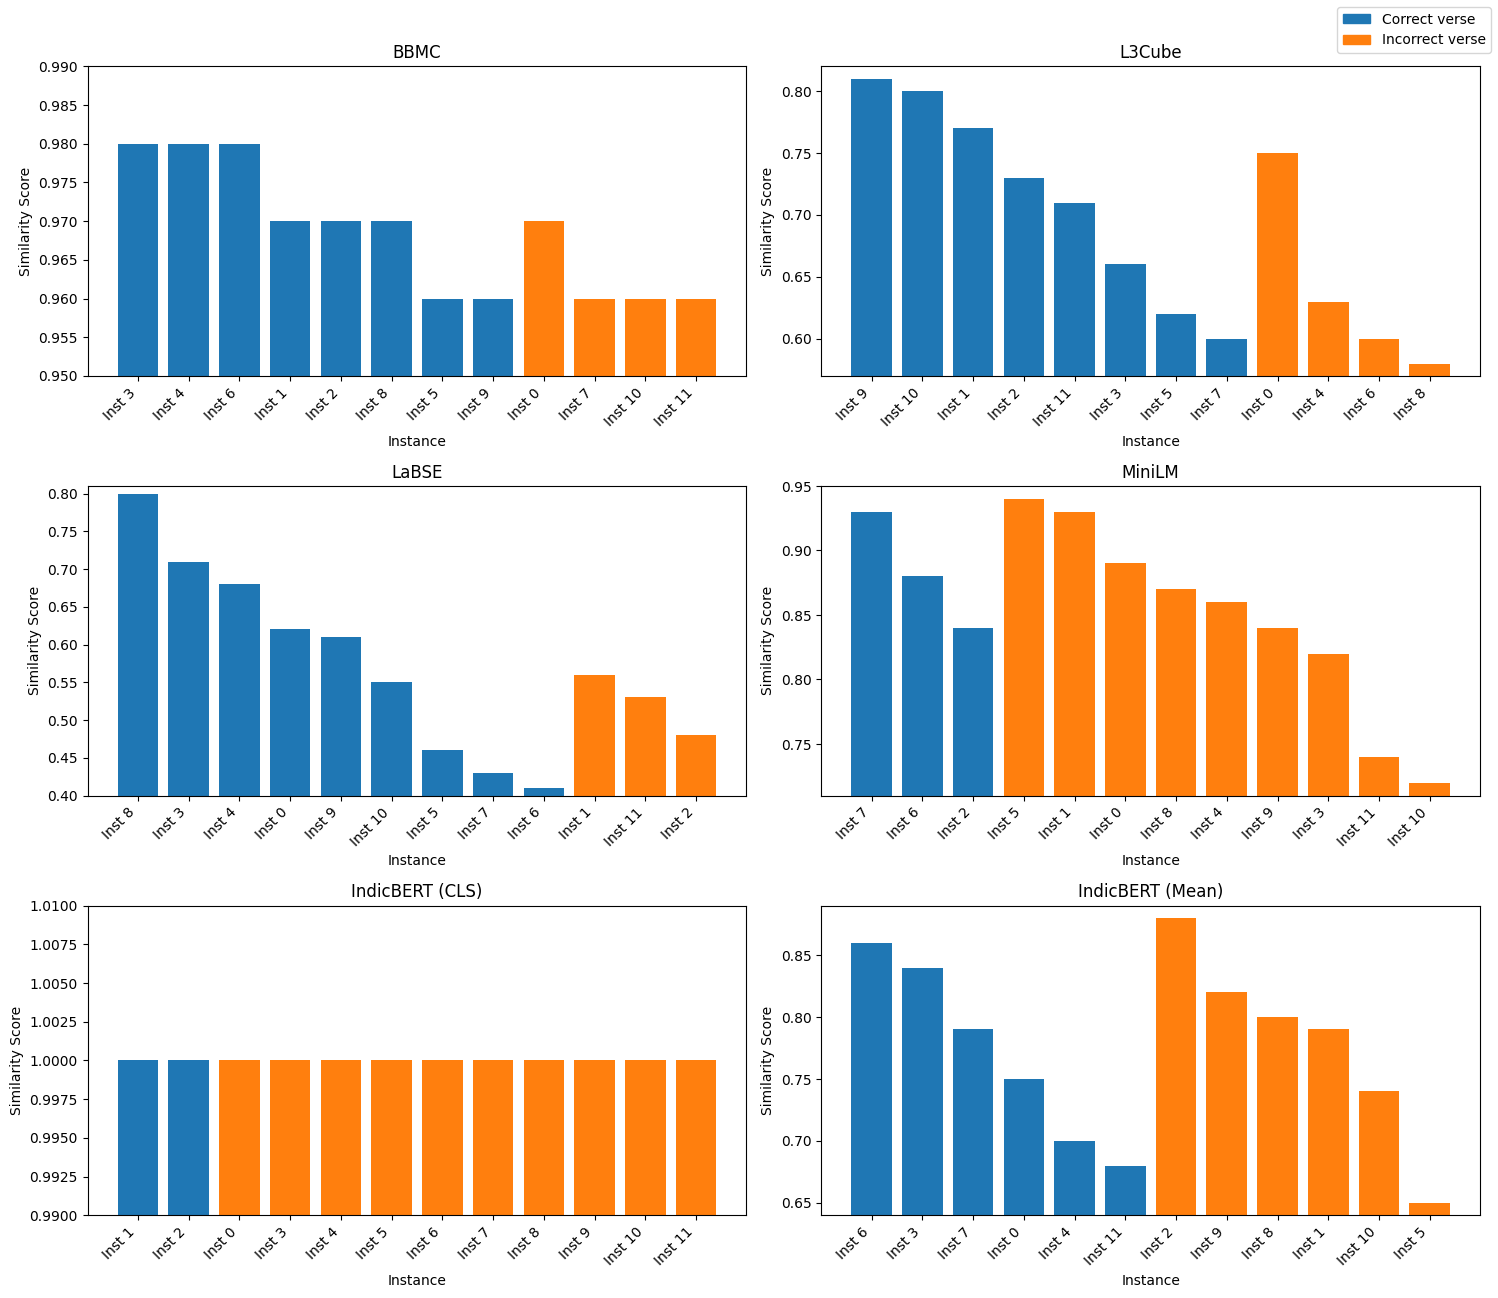

In [42]:
plot_similarity_by_status(models_to_test, mixed_statuses, mixed_scores)

In [43]:
shabad_data['pages_data']['page_1'][0]['shabad_id']

628

In [44]:
#TODO:
# 1. Add logic so that if all the words of a verse have not been spoken, we will not switch to the next verse. This might be tricky because ragis could, 
# in principle, just sing a few words of a tuk and switch to another. Usually, these would only be the ending words of a verse i.e. they might sing
# 'kaaj savare' multiple times. But it is unlikely that they will sing the first few words of a verse multiple times without saying the next ones
# in the verse.
# 2. The 3-word method will fail when very similar lines are being spoken. For example, in Sukhmani Sahib, there are multiple lines starting with
#    'prabh ke simran'. Similarly, in Bhai Nand Lal's vaaran, there are repeated lines like 
#     'Nasro Mansoor Gur Gobind Singh,... Hak hak aaena Gur Gobind Singh' etc. where 'Gur Gobind Singh' is repeated. In such instances, picking 
#      one verse with the highest cosine similarity will fail. To fix this, we have to have a logic along the lines of:
#    a) Find cosine similarity with all verses
#    b) Pick the one with the highest similarity, provided that the cosine similarity of the highest one is above a certain threshold AND the difference
#       between the highest and second highest is more than a separate threshold. If both of these conditions aren't satisfied, wait to hear more words
#       and try verse matching with a larger dataset.
# Make the initial shabad identification method more robust if need be

**Automatic Speech Recognition**

In [45]:
# TODO:
# Try https://huggingface.co/gagan3012/wav2vec2-xlsr-punjabi
# Need to search more for other models. Google speech to text is amazing and we can leverage their $300 free credits as well.

In [47]:
banidb.__version__

'0.1'